In [1]:
import torch

print(torch.__version__)

# Path: Yolo_v8_PD/Test/t.ipynb
print(torch.backends.mps.is_available())

2.0.1
True


In [2]:
# initialize minimum probability to filter weak detections along with
MIN_CONF = 0.5

# define the minimum safe distance (in pixels) that two people can be
# from each other
MIN_DISTANCE = 700

In [4]:
import cv2
import numpy as np
from PIL import Image
from ultralytics import YOLO

In [5]:
def plot_boxes(img:np.ndarray, results:np.ndarray = None, color:tuple[int, int, int] = [0, 255, 0], boxes =None, line_thickness:int = None, defaulters:list[int] = None):
    if results is None and boxes is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    bboxes= boxes or results.boxes.xyxy.cpu()
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    for idx, box in enumerate(bboxes):
        if defaulters and idx in defaulters:
            color = [255, 255, 0]
        else:
            color = [0, 255, 0]
        c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)

In [6]:
def calc_centroids(results:np.ndarray):
    bboxes= results.boxes.xyxy.cpu()
    centroids = []
    for box in bboxes:
        #box = xyxy[0:4]
        c = int((box[0] + box[2])/2), int((box[1] + box[3])/2)
        centroids.append(c)
    return centroids

In [7]:
def plot_centroids(img:np.ndarray, results:np.ndarray = None, color:tuple[int, int, int] = [0, 255, 0], centroids:list[tuple[int, int]] = None, line_thickness:int = None, defaulters:list[int] = None):
    if results is None and centroids is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    centroids = centroids or calc_centroids(results)
    for idx, centroid in enumerate(centroids):
        if defaulters and idx in defaulters:
            color = [255, 255, 0]
        else:
            color = [0, 255, 0]
        cv2.circle(img =img, center =centroid,radius=5, color=color, thickness=tl)

In [8]:
def show_violations(img:np.ndarray, instances:list[int], results:np.ndarray = None, centroids:list[tuple[int, int]]= None, line_thickness:int = None, color = [0, 255, 0]):
    if results is None and centroids is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    elif centroids is None:
        centroids = calc_centroids(results)

    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    for violation in instances:
        color = [255, 0, 0]
        i, j = violation
        cv2.line(img, centroids[i], centroids[j], color, tl)
    
    # draw the total number of social distancing violations on the output frame
    text = "Social Distancing Violations: {}".format(len(instances))
    cv2.putText(img, text, (10, img.shape[0] - 25),
		cv2.FONT_HERSHEY_SIMPLEX, 1.85, color, tl)

In [9]:
from scipy.spatial import distance as dist
def check_violations (results:dict, source_image:np.ndarray):
	if len(results) >= 2:
		# extract all centroids from the results and compute the
		# Euclidean distances between all pairs of the centroids
		centroids = calc_centroids(results)
		D = dist.cdist(centroids, centroids, metric="euclidean")

		violators = set()
		violations = set()
		# loop over the upper triangular of the distance matrix
		for i in range(0, D.shape[0]):
			for j in range(i + 1, D.shape[1]):
				# check to see if the distance between any two
				# centroid pairs is less than the configured number
				# of pixels
				if D[i, j] < MIN_DISTANCE:
					# update our violation set with the indexes of
					# the centroid pairs
					violators.add(i)
					violators.add(j)
					violations.add((i, j))
					print(f"violation: {D[i, j]}")
		
	# return the set of violations
	return violators, violations
		

In [10]:
def draw_results(results:dict, source_image:np.ndarray):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image (np.ndarray): for drawing predictions of the format [x1, y1, x2, y2]
        source_image (np.ndarray): input image for drawing bounding boxes and centroids
    Returns:    
    """
    # boxes = results.boxes.data.cpu()
    # centroids = calc_centroids(results)
    # print(centroids)

    violators, violations = check_violations(results, source_image)
    
    # Plot the bounding boxes of the people detected
    plot_boxes(source_image, results, defaulters=violators)#, boxes=boxes)

    # Plot the centroids of the people detected
    plot_centroids(source_image, results, defaulters=violators)#, centroids=centroids)

    # Plot lines between centroids of people violating social distancing
    show_violations(source_image, instances= violations, results=results)#, centroids=centroids)
    

In [28]:
!cd ..
!cd ..
!ls

Yolo v8 on image.ipynb Yolo v8 on video.py


Ultralytics YOLOv8.0.43 🚀 Python-3.11.3 torch-2.0.1 CPU
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

0: 384x640 2 persons, 45.4ms
Speed: 0.3ms preprocess, 45.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


violation: 430.5124853009492


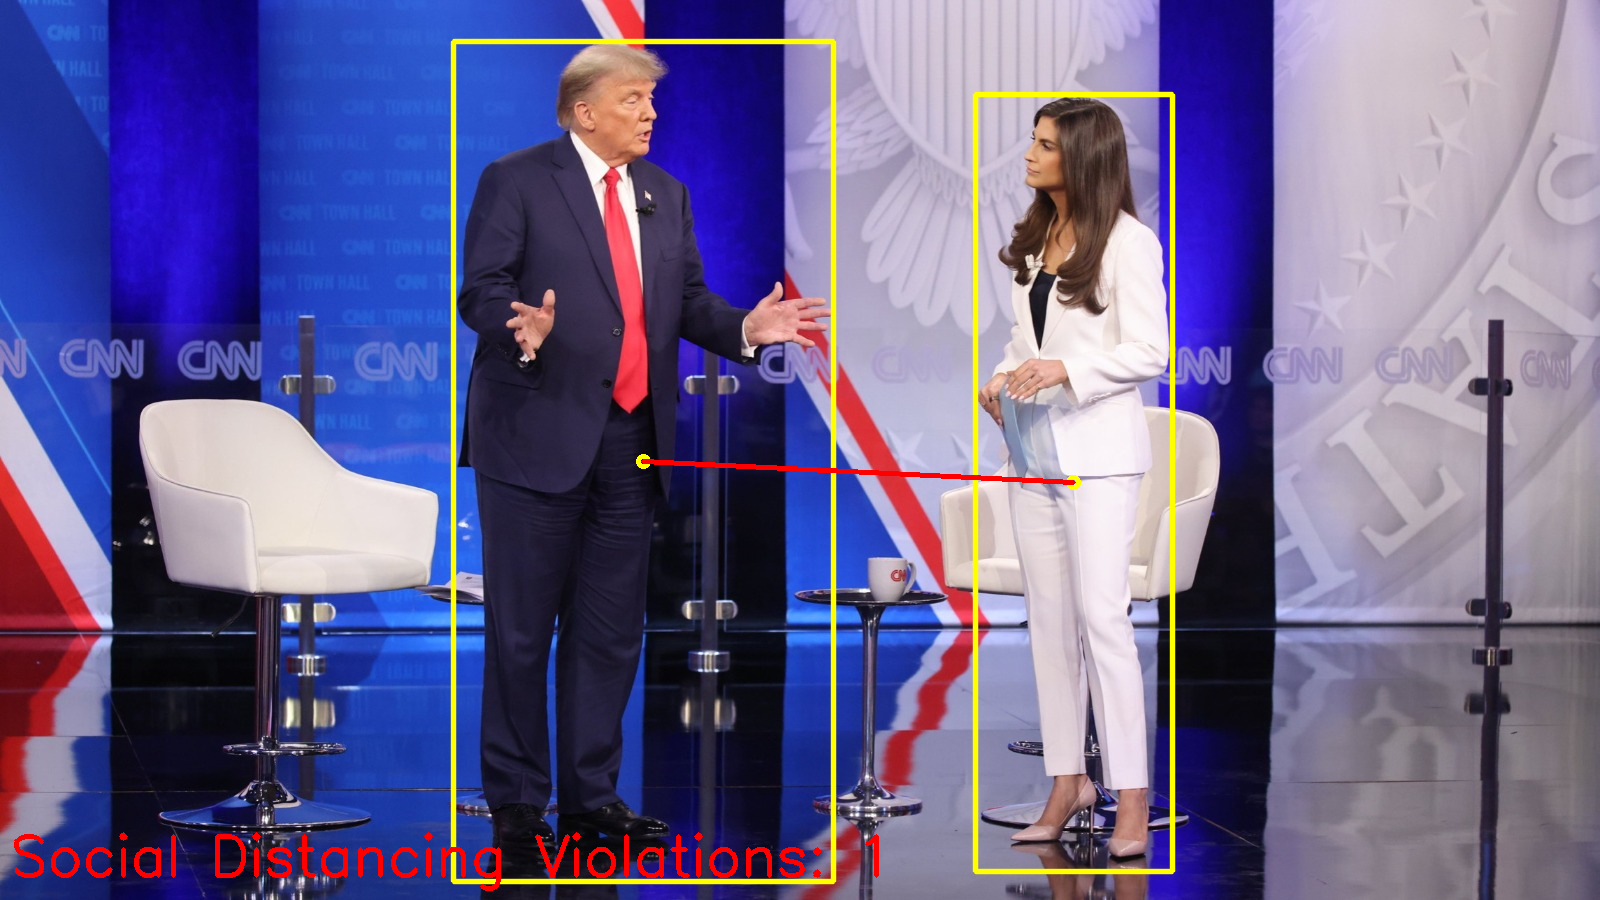

In [32]:
# Reading the image
img = cv2.imread("t.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model
results = model(img, classes=0, conf= MIN_CONF)  # predict on an image
#print(results[0].boxes.data)  # print results to screen
draw_results(results[0], img)
Image.fromarray(img)